# Vanilla Gradients 

Image gradients are a fundamental concept in image processing and computer vision, capturing how pixel intensities change across an image. Understanding vanilla gradients, or the basic calculation of image gradients, provides a crucial foundation for more advanced image analysis tasks. In this tutorial, we will delve into calculating gradients for color images, and visualizing their results by generating so called saliency maps. Get ready to see how image gradients can reveal the structure and details within your images :smile:.

__Step 1:__ Load the required libraries.

In [9]:
import os
import numpy as np
import tensorflow
import skimage as ski
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import concurrent.futures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, Dropout
from keras.optimizers import Adam

:bell: You are free to add any library you deem necessary to successfully complete this homework assignment! 

For this tutorial, we will use a Cats vs. Dogs dataset, which consists of images featuring the two distinct animal classes. To make data preprocessing easier, we have already organized the images into separate folders. You will find a 'train' folder containing images used to train your model and a 'test' folder with images for evaluating your model's performance. You can download the preprocessed dataset, [here](https://edubuas-my.sharepoint.com/:f:/g/personal/blerck_i_buas_nl/Egas9AxZzg1MrAE8f8RtErwB1Xy1CKhaNiHQX9hJjTT4Ew?e=WbD2Md). 

__Step 2:__ Download the Cats vs. Dogs dataset, and and assign the paths to the train and test set folders to the variables ```src_path_train``` and ```src_path_train```. 

In [2]:
src_path_train = '/cats_and_dogs/train' # e.g., './cats_and_dogs/train'
src_path_test = '/cats_and_dogs/test'  # e.g., './cats_and_dogs/test'

# THE IMAGES WERE NOT SEPARATED SO I HAD TO MANUALLY SPLIT THEM

__Step 3:__ Pre-process your data: 

- Rescale the images to have pixel values between 0 and 1.
- Resize the images to 224x224 pixels.
- Ensure that the images are in the correct format (e.g., RGB).
- One-hot encode the labels.
- Apply other preprocessing steps, such as horizontal flip and zoom, as necessary. 

In [8]:
# Folder paths where the images of each class are stored
folder_paths = ['cats_and_dogs/cats','cats_and_dogs/dogs']

# Class labels for the images (same order as folder_paths)
class_names = ["cats", 'dogs']

# Target size to resize the images
target_size = (224, 224)

# Arrays to store the images (X) and class labels (y)
X = []
y = []

for i in range(len(folder_paths)):
    for filename in os.listdir(folder_paths[i]):
        file_extension = os.path.splitext(filename)[1]
        # Check if the file extension is an image extension 
        if file_extension == ".jpg" or file_extension == ".jpeg" or file_extension == ".png": 
            image_filename = os.path.join(folder_paths[i], filename)
            # Read the image file using scikit-image
            image = ski.io.imread(image_filename)
            # Normalize the image to values between 0 and 1
            image = image / 255.0
            # Resize the image to the target_size
            image_resized = ski.transform.resize(image, target_size)            
            # Insert the image into array X
            X.append(image_resized)
            # Insert the class label into array y
            y.append(class_names[i])
            
# Convert of arrays into numpy arrays
X = np.array(X)
y = np.array(y)

_Applied data augmentation preprocessing techniques_

In [12]:
data_gen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2)

def GenerateImages(generator, image, num_images):
    new_images = []
    # we need to reshape the image because the generator.flow() 
    # expects an array of images
    image = np.reshape(image, (1,) + image.shape)
    for _ in range(num_images):
        batch = next(generator.flow(image, batch_size=1))
        new_images.append(batch[0])
    return np.array(new_images)

# Save the images to a new dataset 'X_augmented' and 'y_augmented'
X_augmented = []
y_augmented = []
for index in range(len(X)):
    images = GenerateImages(data_gen, X[index], 6)
    for i in range(6):
        X_augmented.append(images[i])
        y_augmented.append(y[index])  

# Convert lists to numpy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Encode the class labels into integers
label_encoder = LabelEncoder()
y_integer_encoded = label_encoder.fit_transform(y_augmented)  
num_classes = len(np.unique(y_integer_encoded))
y_onehot_encoded = keras.utils.to_categorical(y_integer_encoded, num_classes=num_classes)

__Step 4:__ Split your dataset into an 80% training set, 10% validation set, and 10% test set, and assign the sets to the following variables as a numpy array: ```X_train```, ```X_val```, ```X_test```, ```y_train```, ```y_val```, and ```y_test```.

In [13]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented,
                                                    y_onehot_encoded,
                                                    test_size=1/10,
                                                    random_state=0)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 1/10,
                                                  random_state = 0)

__Step 5:__ Design a Sequential model using the Keras API. Include at least one Conv2D layer for feature extraction, a Flatten layer to prepare the data for classification, and two Dense layers. Leave the second-to-last Dense layer without an activation function, but apply a softmax activation to the final output layer.

In [14]:
# Create a sequential model
model = Sequential()

# Add convolutional layers, max pooling, and dropout layers
model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=target_size + (3,), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(10, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(2, activation='softmax'))

__Step 6:__ Compile your model, and train it using the training and validation sets.

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', 
                       patience=3)

# Train the model 
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=monitor_val_acc)

Epoch 1/100


456/456 [==============================] - 74s 162ms/step - loss: 0.6423 - accuracy: 0.6285 - val_loss: 0.6087 - val_accuracy: 0.6728
Epoch 2/100
456/456 [==============================] - 79s 172ms/step - loss: 0.5393 - accuracy: 0.7250 - val_loss: 0.6281 - val_accuracy: 0.6642
Epoch 3/100
456/456 [==============================] - 79s 173ms/step - loss: 0.3773 - accuracy: 0.8283 - val_loss: 0.8446 - val_accuracy: 0.6586
Epoch 4/100
456/456 [==============================] - 80s 175ms/step - loss: 0.1927 - accuracy: 0.9232 - val_loss: 1.0603 - val_accuracy: 0.6494


__Step 7:__ To compute a saliency map, you will need to create a new model that mirrors the structure of your original model but outputs the logits instead of the final class predictions. To achieve this, use the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class, providing the same input as your original model and specifying the output of the second-to-last layer as the output of your new model. This new model will provide the raw scores needed for calculating the saliency map.

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/8ZcccMzTz7Y?si=0qbDBm0E662dFZYy" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

*Video 1. What is a Logit?*

In [18]:
class MyModel(keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = keras.layers.Conv2D(10, kernel_size=3, activation='relu', input_shape=target_size + (3,), padding='same')
        self.maxpooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = keras.layers.Conv2D(10, kernel_size=3, activation='relu')
        self.maxpooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.dense2 = keras.layers.Dense(64, activation='relu')
        self.output_layer = keras.layers.Dense(2)  # Output layer without activation for logits
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpooling1(x)
        x = self.conv2(x)
        x = self.maxpooling2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.output_layer(x)

# Create an instance of your model
logits_model = MyModel()

__Step 8:__ A saliency map acts like a spotlight on your image, highlighting the pixels that were most crucial (i.e.., red color spectrum) for the model when making a specific prediction. In the next code block, we will define a function named ```get_saliency_map``` that calculates this map for a given image and class. Run the code block: 

In [19]:
def get_saliency_map(model, image, class_idx):
    # Element 1
    with tf.GradientTape() as tape: 
        tape.watch(image)

        predictions = model(image, training=False) # Element 2
        loss = tf.reduce_max(predictions[:, class_idx]) # Element 3
    gradient = tape.gradient(loss, image) # Element 4

    # Element 5
    gradient = tf.reduce_max(gradient, axis=-1)
    gradient = gradient.numpy()
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + tf.keras.backend.epsilon())
    return smap

Let us dive into the function step-by-step, including the core math that makes it work:

- Element 1: TensorFlow's GradientTape is a context manager used for automatic differentiation, allowing you to compute gradients of a computation with respect to some inputs. Automatic differentiation is crucial for training neural networks. Here, it's used to calculate the gradients of a loss function with respect to the input image pixels. The tape.watch(image) call ensures that the image tensor is being tracked by the tape, allowing gradients with respect to it to be computed.

- Element 2: This line feeds the input image to the model to obtain the predictions. The model outputs logits or raw predictions for each class, which have not been normalized by the softmax layer yet. The training=False argument ensures that the model runs in inference mode, so operations like dropout or batch normalization are executed in their inference configuration.

- Element 3: The loss is calculated as the maximum logit value for the target class (class_idx). Mathematically, if $p$ represents the prediction vector for the image, and $p_i$ is the prediction (logit) for the target class, then the loss $L$ can be expressed as: 
$$L = max(p_i) $$
where $i$ is the index of the target class. This step focuses the gradient computation on the class of interest.

- Element 4: Here, we compute the gradient of the loss $L$ with respect to the input image. This gradient tells us how small changes in the input image pixels would affect the change in the computed loss. Mathematically, if $X$ represents the input image, then the gradient $\nabla{_xL}$ is the vector of partial derivatives: 

$$\nabla_{\mathbf{x}}L = \left[ \frac{\partial L}{\partial x_1}, \frac{\partial L}{\partial x_2}, \ldots, \frac{\partial L}{\partial x_n} \right]$$

where each $\frac{\partial L}{\partial x_i}$​ represents how much a tiny increase in pixel $i$'s value would increase the loss, holding all other pixels constant.

- Element 5: The gradient obtained in the previous step has the same shape as the input image (i.e., height x width x channels). To simplify it into a 2D saliency map, we use reduce_max across the color channels, effectively taking the maximum gradient magnitude across all channels for each pixel. This resulting 2D gradient map is then normalized to the range [0, 1] to make it suitable for visualization. The normalization is done by subtracting the minimum gradient value from all pixels and then dividing by the range of gradient values (i.e. Min-Max scaling). This process scales the gradient magnitudes to fit within a standard viewing range, highlighting the pixels most relevant to the model's prediction. 

Mathematically, the normalized saliency map $S$ for a pixel $x_i$​ is given by:

$$S(x_i) = \frac{x_i - \min(X)}{\max(X) - \min(X)}$$

where $\epsilon$ is a small constant (tensorflow.keras.backend.epsilon()) added to prevent division by zero in case the maximum and minimum gradients are the same. Finally, the function returns the normalized saliency map, smap.

__Step 9:__ Run the code block below, and let us see the results of the saliency map for a given image and class :tada:


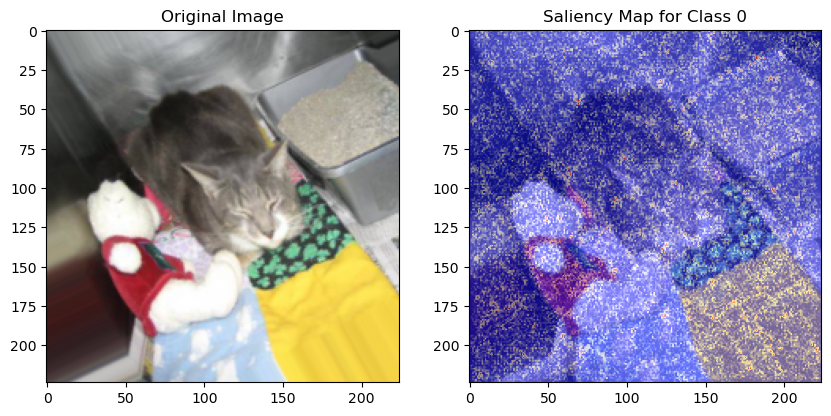

In [20]:
img_array = X_test[8] # Image to explain
target_class = np.argmax(y_test[8]) # Class to explain

saliency_map = get_saliency_map(logits_model, tf.expand_dims(img_array, 0), target_class)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img_array)
plt.imshow(saliency_map[0], cmap='seismic', alpha=0.5)
plt.title(f'Saliency Map for Class {target_class}')
plt.show()

When you have successfully implemented the function, you should receive a saliency map that highlights the most important pixels for the model's prediction. For example: 

![Vanilla Gradients and Cat Image](https://edirlei.com/images/vanilla_gradients_cat.png)